# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import datetime
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier,DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.classification import SVMModel
from time import time


In [2]:
# create a Spark session
spark = SparkSession.builder\
    .master('local')\
    .appName('event')\
    .getOrCreate()

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [3]:
sparkify_event_data = 'mini_sparkify_event_data.json'

In [4]:
df = pd.read_json('mini_sparkify_event_data.json',lines=True)

In [5]:
spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.app.id', 'local-1582972616047'),
 ('spark.driver.port', '57797'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '192.168.0.103'),
 ('spark.app.name', 'event'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [6]:
pd.isnull(df).sum()

ts                   0
userId               0
sessionId            0
page                 0
auth                 0
method               0
status               0
level                0
itemInSession        0
location          8346
userAgent         8346
lastName          8346
firstName         8346
registration      8346
gender            8346
artist           58392
song             58392
length           58392
dtype: int64

In [7]:
# 已经有用户id来区分用户，所以删除用户名和注册信息
df = df.drop(['firstName', 'lastName', 'registration', 'status', 'itemInSession', 'method', 'sessionId'],axis = 1)

In [8]:
df[df.artist.isnull()].sample(5)

,ts,userId,page,auth,level,location,userAgent,gender,artist,song,length
58101,1539834041000,,Home,Logged Out,free,NaN,NaN,NaN,NaN,NaN,NaN
149927,1542078140000,131,Add Friend,Logged In,paid,"Kingsport-Bristol-Bristol, TN-VA","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",M,NaN,NaN,NaN
35621,1539261715000,,Login,Logged Out,paid,NaN,NaN,NaN,NaN,NaN,NaN
73258,1540199527000,39,Thumbs Up,Logged In,paid,"Los Angeles-Long Beach-Anaheim, CA","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",F,NaN,NaN,NaN
233742,1539891932000,200018,Roll Advert,Logged In,free,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD","""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",M,NaN,NaN,NaN


artist为空是由于用户访问非播放页面导致的，不做处理

In [9]:
df[df.gender.isnull()].sample(5)

,ts,userId,page,auth,level,location,userAgent,gender,artist,song,length
56629,1539798659000,,Login,Logged Out,paid,NaN,NaN,NaN,NaN,NaN,NaN
49417,1539683419000,,Login,Logged Out,paid,NaN,NaN,NaN,NaN,NaN,NaN
18429,1538883728000,,Home,Logged Out,paid,NaN,NaN,NaN,NaN,NaN,NaN
265788,1540540635000,,Home,Logged Out,paid,NaN,NaN,NaN,NaN,NaN,NaN
209410,1543513279000,,Login,Logged Out,free,NaN,NaN,NaN,NaN,NaN,NaN


gender为空是由于非注册用户访问导致的，直接删除即可

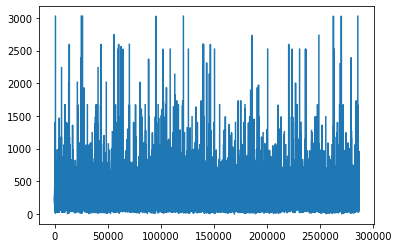

In [21]:
plt.plot(df.length)

听歌时长均小于3000s，符合常识

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

In [10]:
df.head(2)

,ts,userId,page,auth,level,location,userAgent,gender,artist,song,length
0,1538352117000,30,NextSong,Logged In,paid,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,M,Martha Tilston,Rockpools,277.89016
1,1538352180000,9,NextSong,Logged In,free,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",M,Five Iron Frenzy,Canada,236.09424


In [11]:
df.auth.value_counts()

Logged In     278102
Logged Out      8249
Guest             97
Cancelled         52
Name: auth, dtype: int64

#226名用户中，共有8249次登出行为，52次取消服务行为。用户登出行为过多是否与最终取消服务相关呢？存疑

In [12]:
df.artist.value_counts().head(10)

Kings Of Leon             1841
Coldplay                  1813
Florence + The Machine    1236
Dwight Yoakam             1135
Bj脙聝脗露rk                  1133
The Black Keys            1125
Muse                      1090
Justin Bieber             1044
Jack Johnson              1007
Eminem                     953
Name: artist, dtype: int64

In [13]:
df.song.value_counts().head(10)

You're The One                                                         1153
Undo                                                                   1026
Revelry                                                                 854
Sehr kosmisch                                                           728
Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile)     641
Dog Days Are Over (Radio Edit)                                          574
Secrets                                                                 466
Use Somebody                                                            459
Canada                                                                  435
Invalid                                                                 424
Name: song, dtype: int64

#听热门歌曲和听冷门歌曲的用户是否具有相同的行为习惯呢？存疑，可统计用户收听的热门/冷门歌曲数量，歌手同理，可统计用户收听的热门/冷门歌手数量
#不同行为习惯的人喜欢的歌曲风格是不同的，根据一个人的歌曲品味也许能推断出一个人的行为，如果有单独的统计歌曲风格的数据集应该会对分析有帮助
#一个用户如果对同一首歌在不同时间段内多次重复播放，而这首歌又是平台独有的那么他极可能不会取消服务，可以统计每位用户收听最多歌曲的收听次数/总收听次数。艺术家同理，统计收听最多艺术家的收听次数/总收听次数
#用户对歌曲的"专一度"如何呢？用户对歌曲的专一是否与对平台的专一相关呢？统计用户收听超过5次的歌曲数目和收听次数/总播放数。以及收听超过5次的艺术家数目和收听次数/总播放数

In [14]:
df.page.value_counts()

NextSong                     228108
Home                          14457
Thumbs Up                     12551
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Login                          3241
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Help                           1726
Settings                       1514
About                           924
Upgrade                         499
Save Settings                   310
Error                           258
Submit Upgrade                  159
Submit Downgrade                 63
Cancellation Confirmation        52
Cancel                           52
Register                         18
Submit Registration               5
Name: page, dtype: int64

#听歌越多用户的点赞数应该会越高，可收集每个用户的点赞次数
#用户对歌曲赞/踩比（Thumbs Up/Thumbs Down）可能与用户对平台的喜好程度有关，或许也与客户流失有关系
#用户升级过业务，说明他们认可平台提供的服务，很可能他们不会取消服务，统计用户是否升级业务，同理若用户发生了降级的行为，很可能代表他们不喜欢平台的服务，统计用户是否降级了业务
#每个用户添加到歌单的歌曲数量是多少？也许与取消服务相关？统计每个用户每月添加到歌单的歌曲数

In [15]:
df.userAgent.value_counts()

"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                22751
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"                        19611
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                     18448
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                     17348
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                                       16700
"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                                15395
"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/53

#用户使用最多的电脑产品时苹果电脑，可将用户设备区分为苹果/其他

In [16]:
df.head()

,ts,userId,page,auth,level,location,userAgent,gender,artist,song,length
0,1538352117000,30,NextSong,Logged In,paid,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,M,Martha Tilston,Rockpools,277.89016
1,1538352180000,9,NextSong,Logged In,free,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",M,Five Iron Frenzy,Canada,236.09424
2,1538352394000,30,NextSong,Logged In,paid,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,M,Adam Lambert,Time For Miracles,282.82730
3,1538352416000,9,NextSong,Logged In,free,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",M,Enigma,Knocking On Forbidden Doors,262.71302
4,1538352676000,30,NextSong,Logged In,paid,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,M,Daft Punk,Harder Better Faster Stronger,223.60771


In [17]:
df.page.value_counts()

NextSong                     228108
Home                          14457
Thumbs Up                     12551
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Login                          3241
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Help                           1726
Settings                       1514
About                           924
Upgrade                         499
Save Settings                   310
Error                           258
Submit Upgrade                  159
Submit Downgrade                 63
Cancellation Confirmation        52
Cancel                           52
Register                         18
Submit Registration               5
Name: page, dtype: int64

<BarContainer object of 4 artists>

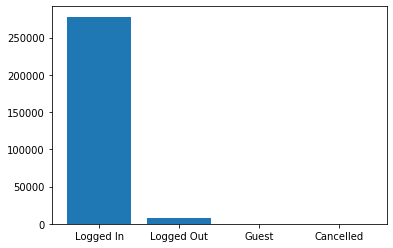

In [44]:
plt.bar(['Logged In','Logged Out','Guest','Cancelled'],df.auth.value_counts())

In [45]:
df.auth.value_counts()

Logged In     278102
Logged Out      8249
Guest             97
Cancelled         52
Name: auth, dtype: int64

<BarContainer object of 2 artists>

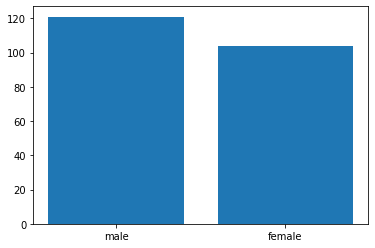

In [47]:
plt.bar(['male','female'],df[['userId','gender']].groupby('userId').max().gender.value_counts())

男女比例差异不大

<BarContainer object of 2 artists>

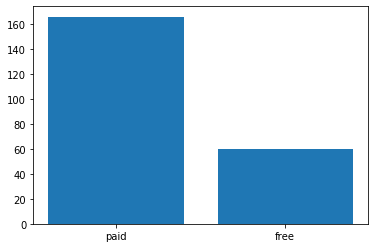

In [43]:
plt.bar(['paid','free'],df[['userId','level']].groupby('userId').max().level.value_counts())

223名用户中付费用户占了160人左右

根据对数据集的初步观察，分析可能的数据处理策略
    #1统计用户收听的热门/冷门歌曲数量，统计用户收听的热门/冷门歌手数量
    #2统计每位用户收听最多歌曲的收听次数。统计收听最多艺术家的收听次数
    #3统计各用户每7天的听歌情况，包括歌曲数目/总时长
    #4男女用户的行为应该有较大差异，可作为特征列
    #5用户共有多少次登出行为
    #6收集每个用户对的赞踩比
    #7统计用户是否升级业务，统计用户是否降级了业务
    #8统计用户收听超过5次的歌曲数目和收听次数/总播放数。以及收听超过5次的艺术家数目和收听次数/总播放数
    #9统计每个用户每月添加到歌单的歌曲数
    #10用户每月的累计收听天数
    #11将用户设备区分为苹果/其他
    #12是否为付费用户
    #13用户的社交情况如何？是否常添加好友？
    #14用户喜欢的艺术家/歌曲数量

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

In [20]:
#读取数据
df_spark = spark.read.json(sparkify_event_data)

#删除空值行
df_spark = df_spark.filter(df_spark.userId != '')

df_spark = spark.createDataFrame(df_spark.head(1000))

In [21]:
#处理datetime列
#转换时间戳
get_time = udf(lambda x : datetime.datetime.fromtimestamp(x/1000))
df_spark = df_spark.withColumn('dateTime', get_time(df_spark.ts))

#datetime记录了从整个10/11月和12月初的数据，进行转换，计算各日期距离10月1日的天数，存为"days"列
def get_day(x):
    a = x.month
    if a == 12:
        return 61+x.day
    return 31 * (x.month - 10) + x.day

getDay = udf(get_day)
df_spark = df_spark.withColumn('days', getDay(df_spark.dateTime))

In [22]:
#处理level,gender列
#转换level,gender列为数字
change_type_level = udf(lambda x : int(x == 'paid'),IntegerType())
df_spark = df_spark.withColumn('isPaid', change_type_level(df_spark.level))
df_spark = df_spark.drop('level')

change_type_gender = udf(lambda x : int(x == 'M'),IntegerType())
df_spark = df_spark.withColumn('isMale', change_type_gender(df_spark.gender))
df_spark = df_spark.drop('gender')

In [23]:
#处理userAgent列
#用户使用的是否为苹果设备
is_apple = udf(lambda x : 1 if x >0 else 0, IntegerType())
df_spark = df_spark.withColumn('isApple', is_apple(instr(df_spark.userAgent, 'Mac')))

In [24]:
#处理page列
def udf_is_equal(target_col, result_col, df):
    """处理page中的值"""
    udf_ = udf(lambda x : int(x == target_col),IntegerType())
    return df.withColumn(result_col, udf_(df.page))
#page列需要转换的页面名
transform_list = ['Cancel','Thumbs Up','Add Friend','Add to Playlist'\
                  ,'Logout','Login','Roll Advert','Downgrade','Error'\
                  ,'Upgrade','Submit Upgrade','Submit Downgrade']
#转换为独热列并添加到df_spark
for i in transform_list:
    df_spark = udf_is_equal(i, i.replace(' ',''), df_spark)

In [25]:
#接下来按照用户进行统计
def agg_max_by_id(column_name,df_spark):
    """将df_spark中的列按照userId进行汇总"""
    return df_spark\
        .groupBy('userId')\
        .agg({column_name:'max'})\
        .withColumnRenamed('max('+column_name+')',column_name)

In [26]:
#创建目标dataframe——df_target
df_target = agg_max_by_id('isPaid',df_spark)

#需要独热的行
column_one_hot = ['isMale','isApple','Cancel','logOut','downgrade','error','submitUpgrade']

#转换需要独热的行
for i in column_one_hot:
    right_df = agg_max_by_id(i, df_spark)
    df_target = df_target\
        .join(right_df, df_target.userId == right_df.userId)\
        .drop(right_df.userId)

#需要count计数的行
column_count = ['thumbsUp','addFriend','length','logIn','RollAdvert','upgrade']

#转换需要count计数的行
for i in column_count:
    right_df = df_spark\
        .groupBy('userId')\
        .agg({i:'sum'})\
        .withColumnRenamed('sum('+i+')', i)
    df_target = df_target\
        .join(right_df, df_target.userId == right_df.userId)\
        .drop(right_df.userId)

#统计每日听歌数据
days_value = df_spark.select('days').dropDuplicates().collect()
for i in days_value:
    #统计每一天各用户的听歌数量
    right_df = df_spark\
        .filter(df_spark.days == i.days)\
        .groupBy('userId').count()\
        .withColumnRenamed('count','day'+i.days+'SongCount')
    #合并到df_target
    df_target = df_target\
        .join(right_df, df_target.userId == right_df.userId)\
        .drop(right_df.userId)
    #统计每一天各用户的听歌时长
    right_df = df_spark\
        .filter(df_spark.days == i.days)\
        .groupBy('userId')\
        .agg({'length':'sum'})\
        .withColumnRenamed('sum(length)','day'+i.days+'SumLength')
    df_target = df_target\
        .join(right_df, df_target.userId == right_df.userId)\
        .drop(right_df.userId)

In [27]:
#用户总共听了多少个艺术家的歌？
right_df = df_spark\
    .groupBy('userId')\
    .agg({'artist':'count'})
df_target = df_target\
    .join(right_df, df_target.userId == right_df.userId)\
    .drop(right_df.userId)

In [28]:
#用户总共听了多少歌
right_df = df_spark\
    .groupBy('userId')\
    .agg({'song':'count'})
df_target = df_target\
    .join(right_df, df_target.userId == right_df.userId)\
    .drop(right_df.userId)

In [29]:
#用户平均听歌时长
right_df = df_target\
    .select('userId', df_target['length']/df_target['count(song)'])\
    .withColumnRenamed('(length / count(song))', 'lengthBySong')
df_target = df_target\
    .join(right_df, df_target.userId == right_df.userId)\
    .drop(right_df.userId)

In [30]:
#用户访问home页面之后的平均听歌数量
function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = df_spark.filter((df_spark.page == 'NextSong') | (df_spark.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', sum('homevisit').over(user_window))
right_df = cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'})\
    .groupBy('userId')\
    .agg({'count(period)':'avg'})\
    .withColumnRenamed('avg(count(period))','avgSongVistHome')\
    .drop('period')
df_target = df_target.join(right_df, df_target.userId == right_df.userId)\
    .drop(right_df.userId)

In [31]:
#提取需向量化的列
target_column = df_target.columns

target_column.remove('userId')
target_column.remove('Cancel')

from pyspark.ml.linalg import SparseVector,DenseVector

In [32]:
#向量化
df_target = VectorAssembler(inputCols = target_column, outputCol = 'VecFeatures').transform(df_target)

df_feature_label = df_target.select('cancel','VecFeatures')

In [33]:
denseVect = udf(lambda x : DenseVector(x),IntegerType())
m = df_feature_label.withColumn('denvFeature',denseVect(df_feature_label.VecFeatures)).drop('VecFeatures')

In [34]:
#归一化数据
mmscaler = MinMaxScaler(inputCol='VecFeatures',outputCol='features')
model = mmscaler.fit(df_feature_label)

df_feature_label = model.transform(df_feature_label)

In [35]:
df_feature_label = df_feature_label.withColumnRenamed('cancel','label')
#df_feature_label = df_feature_label.withColumnRenamed('VecFeatures','features')

In [36]:
df_feature_label.printSchema

<bound method DataFrame.printSchema of DataFrame[label: int, VecFeatures: vector, features: vector]>

In [37]:
del df_spark
del df_target
del df

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [71]:
trainingData, testData, valData = df_feature_label.randomSplit([0.6,0.2,0.2],42)

In [76]:
t0 = time()

In [77]:
#使用逻辑回归训练模型
lr = LogisticRegression(maxIter = 20, regParam = 0.0, elasticNetParam=0)

# 网格搜索
grid_lr = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.2, 0.4, 0.8])\
    .build()
#交叉验证
crossval_lr = CrossValidator(estimator=lr
              ,estimatorParamMaps = grid_lr
              ,evaluator= MulticlassClassificationEvaluator())

crossval_lr_fit = crossval_lr.fit(trainingData)

result_training_lr = crossval_lr_fit.transform(trainingData)
result_test_lr = crossval_lr_fit.transform(testData)
result_val_lr = crossval_lr_fit.transform(valData)

In [78]:
#评估f1_score
evaluator = MulticlassClassificationEvaluator()

In [79]:
#训练集f1
evaluator.evaluate(result_training_lr)

0.6830223695111848

In [80]:
#测试集f1
evaluator.evaluate(result_test_lr)

0.7337766567301078

In [81]:
#验证集f1
evaluator.evaluate(result_val_lr)

0.5841784989858012

In [82]:
#运行时间
print(time()-t0)

1896.9797356128693


In [46]:
t0 = time()

In [83]:
dt = DecisionTreeClassifier()

In [84]:
model_dt = dt.fit(trainingData)

In [85]:
result_training_dt = model_dt.transform(trainingData)
result_test_dt = model_dt.transform(testData)
resulr_val_dt = model_dt.transform(valData)

In [86]:
#训练集f1
evaluator_f1.evaluate(result_training_dt)

0.8535524179956814

In [87]:
#测试集f1
evaluator_f1.evaluate(result_test_dt)

0.6914765906362546

In [88]:
#验证集f1
evaluator_f1.evaluate(resulr_val_dt)

0.7036625971143174

In [89]:
# 使用随机森林训练模型
rf = RandomForestClassifier(maxDepth = 5, minInstancesPerNode = 2)

In [90]:
grid_rf = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [4, 6, 8])\
    .addGrid(rf.minInstancesPerNode, [1,2])\
    .build()

In [91]:
#交叉验证
crossval_rf = CrossValidator(estimator = rf\
                            ,estimatorParamMaps = grid_rf\
                            ,evaluator = MulticlassClassificationEvaluator())
crossval_rf_fit = crossval_rf.fit(trainingData)

result_training_rf = crossval_rf_fit.transform(trainingData)
result_test_rf = crossval_rf_fit.transform(testData)
result_val_rf = crossval_rf_fit.transform(valData)

In [92]:
#训练集f1
evaluator_f1.evaluate(result_training_rf)

0.9248340922729359

In [93]:
#测试集f1
evaluator_f1.evaluate(result_test_rf)

0.7652741347322628

In [95]:
#验证集f1
evaluator_f1.evaluate(result_val_rf)

0.6479031804109204

In [ ]:
#运行时间
print(time()-t0)

选择随机森林为最终的模型，他在验证集上的f1_score是0.6479031804109204

# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。